# Quick introduction
The goal of this project is to reduce the patience doctor ratio for Zambian clinics and hospitals. One of the ways in which we can archive this is explore the common issues that patients see a doctor for and attempt to find alternative ways in which those issue can be found. OOne of the the issues topping the list was that of skin infections. In this notebook, will train a model that uses deep lesrning to distingusih betwwen various skin deaseses.

## Undestanding skin infections
There are mulptiple types of skin deases that have varrying implications from death threatening to naive ones that may not require immideate intervention. Severity here ranges from trivial mosquito bites, irritations due to allegies, blister all the way to more complex ones likes STD's and Cellulitis which may require medical emergence upon suspision. 

## Datasets
For the training, we will be using the Skin Disease Dataset from kagle availabe [here](https://www.kaggle.com/data/58249) which consists of over 23000 images of different kinds of skin infections.

We begin by declaring all the imports that will reuired for the traing as indicated below.

In [0]:
from __future__ import print_function, division
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms, models
import torchvision
from PIL import Image
import numpy as np
from collections import OrderedDict
import time
import copy
from datetime import datetime
import cv2
import os

In [11]:
!wget https://www.dropbox.com/s/3finhc1nclzoo8t/atlas2oversampled.tag.gz?dl=0 -O data.tar.gz

--2020-05-04 08:24:22--  https://www.dropbox.com/s/3finhc1nclzoo8t/atlas2oversampled.tag.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3finhc1nclzoo8t/atlas2oversampled.tag.gz [following]
--2020-05-04 08:24:23--  https://www.dropbox.com/s/raw/3finhc1nclzoo8t/atlas2oversampled.tag.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf708fcb6ddc27b2f89d12788bc.dl.dropboxusercontent.com/cd/0/inline/A3GObRIlvidbrofJ5PJPypUl-UNzIYHUt5ekNG0pP1L6rAaar129_dQpEDGjqmVIvFSNCKESnS9yOWdG_mrmI-Ej5ifn0ZvAkjWY23m6JE9TnB_TZ_-0iDTy8YscwEiv3w4/file# [following]
--2020-05-04 08:24:23--  https://ucf708fcb6ddc27b2f89d12788bc.dl.dropboxusercontent.com/cd/0/inline/A3GObRIlvidbrofJ5PJPypUl-UNzIYHUt5ekNG0pP1L6rAaar129_dQpEDGjqmVIvFSNCK

In [12]:
!tar -xvf data.tar.gz

atlas/
atlas/Scabies/
atlas/Scabies/img.jpg
atlas/Scabies/img0.jpg
atlas/Scabies/img1.jpg
atlas/Scabies/img10.jpg
atlas/Scabies/img11.jpg
atlas/Scabies/img12.jpg
atlas/Scabies/img14.jpg
atlas/Scabies/img15.jpg
atlas/Scabies/img16.jpg
atlas/Scabies/img17.jpg
atlas/Scabies/img18.jpg
atlas/Scabies/img19.jpg
atlas/Scabies/img2.jpg
atlas/Scabies/img20.jpg
atlas/Scabies/img21.jpg
atlas/Scabies/img22.jpg
atlas/Scabies/img27.jpg
atlas/Scabies/img28.jpg
atlas/Scabies/img29.jpg
atlas/Scabies/img30.jpg
atlas/Scabies/img31.jpg
atlas/Scabies/img32.jpg
atlas/Scabies/img33.jpg
atlas/Scabies/img34.jpg
atlas/Scabies/img35.jpg
atlas/Scabies/img36.jpg
atlas/Scabies/img37.jpg
atlas/Scabies/img38.jpg
atlas/Scabies/img39.jpg
atlas/Scabies/img40.jpg
atlas/Scabies/img41.jpg
atlas/Scabies/img42.jpg
atlas/Scabies/img43.jpg
atlas/Scabies/img45.jpg
atlas/Scabies/img46.jpg
atlas/Scabies/img47.jpg
atlas/Scabies/img48.jpg
atlas/Scabies/img49.jpg
atlas/Scabies/img51.jpg
atlas/Scabies/img52.jpg
atlas/Scabies/img53.jpg

In [13]:
!pip install split-folders tqdm
import split_folders
split_folders.ratio("atlas", output="Data", seed=1337, ratio=(.8, .2))

Copying files: 101 files [00:00, 4188.13 files/s]


In [14]:
!git clone https://github.com/ufoym/imbalanced-dataset-sampler.git

fatal: destination path 'imbalanced-dataset-sampler' already exists and is not an empty directory.


In [6]:
!pip install imbalanced-dataset-sampler/.

Processing ./imbalanced-dataset-sampler
  Created wheel for torchsampler: filename=torchsampler-0.1-cp36-none-any.whl size=3650 sha256=3649583872d76f07306d66c2aa0debad3d9dfe073e81e4965c91fd00bef42381
  Stored in directory: /root/.cache/pip/wheels/38/2b/6a/c92da1292ef596800afc50058a85ca91c768176288a586ecbe
Successfully built torchsampler


In [0]:
from torchsampler import ImbalancedDatasetSampler

## Loading the data
We load the data from the directory provided and peform image transformations like rotations, horizontal flips etc.. We then load a pre trained model from torchvision and difine a classifer for it.

In [0]:
data_dir = 'Data'
train_dir = data_dir+'/train'
test_dir = data_dir+'/val'

In [20]:
!ls

atlas  Data  data.tar.gz  imbalanced-dataset-sampler  sample_data


# Data preprocessing


In [0]:
class apply_filters:

  def __init__(self, image):
    self.image = image

  def gussian(self, image):
    return cv2.GaussianBlur(image, (5.5),0)

  def median(self, image):
    return cv2.medianBlur(image,5)

  def bilateral(self, image):
    return cv2.bilateralFilter(image,9,75,75)

  def filter(self):
    mFiltered = self.median(self.image)
    bFiltered = self.bilateral(mFiltered)
    return bFiltered


In [0]:
for dirt in os.listdir(train_dir):
  for filename in os.listdir(train_dir+"/"+dirt):
    image = cv2.imread(train_dir+"/"+dirt+"/"+filename)
    filter = apply_filters(image)
    filtered = filter.filter()
    cv2.imwrite(train_dir+"/"+dirt+"/"+filename, filtered)

In [18]:
!ls -alh Data/train/Scabies

total 272K
drwxr-xr-x 2 root root 4.0K May  4 08:24 .
drwxr-xr-x 4 root root 4.0K May  4 08:24 ..
-rwxrwxrwx 1 root root 6.0K May  4 08:24 img0.jpg
-rwxrwxrwx 1 root root 3.8K May  4 08:24 img10.jpg
-rwxrwxrwx 1 root root 3.8K May  4 08:24 img11.jpg
-rwxrwxrwx 1 root root 3.8K May  4 08:24 img12.jpg
-rwxrwxrwx 1 root root 4.7K May  4 08:24 img14.jpg
-rwxrwxrwx 1 root root 3.8K May  4 08:24 img15.jpg
-rwxrwxrwx 1 root root 5.0K May  4 08:24 img16.jpg
-rwxrwxrwx 1 root root 4.2K May  4 08:24 img17.jpg
-rwxrwxrwx 1 root root 3.4K May  4 08:24 img19.jpg
-rwxrwxrwx 1 root root 4.7K May  4 08:24 img1.jpg
-rwxrwxrwx 1 root root 4.0K May  4 08:24 img20.jpg
-rwxrwxrwx 1 root root 3.7K May  4 08:24 img21.jpg
-rwxrwxrwx 1 root root 5.1K May  4 08:24 img22.jpg
-rwxrwxrwx 1 root root 4.7K May  4 08:24 img27.jpg
-rwxrwxrwx 1 root root 2.8K May  4 08:24 img28.jpg
-rwxrwxrwx 1 root root 3.6K May  4 08:24 img29.jpg
-rwxrwxrwx 1 root root 4.1K May  4 08:24 img2.jpg
-rwxrwxrwx 1 root root 2.5K May  4 08:

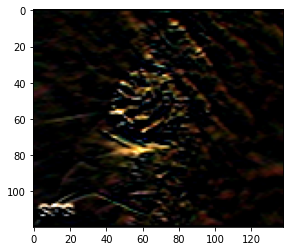

In [67]:
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

filtered = cv2.filter2D(image, -1, sobel_y)
plt.imshow(filtered)

In [68]:
adpttiveThreshold = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

error: ignored

## Data Loading

In [0]:
# peform data transafomrations for the training set.
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# define the dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=20, num_workers=20)
testloader = torch.utils.data.DataLoader(test_dataset, sampler=ImbalancedDatasetSampler(test_dataset),batch_size=20, num_workers=20)
class_names = train_dataset.classes

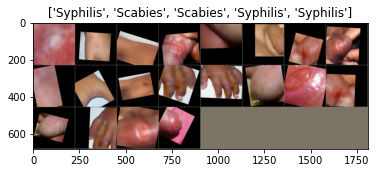

In [22]:
#delete this when the other imshow is working
def imshow(inp, title=None):
  """Imshow for Tensor. """
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause to allow plots to complete

# get a batch from the training data
inputs, classes = next(iter(trainloader))

# make a grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes[:5]])

In [0]:
# download a pre trained model
model_name = 'resnet50'
model = None
model = models.resnet50(pretrained=True)


In [0]:
## Freeze the parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [0]:
# modify the classifier to match the dataset
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(model.fc.in_features, model.fc.out_features)),
    ('ReLU', nn.ReLU()),
    ('fc2', nn.Linear(model.fc.out_features, 512)),
    ('Dropout', nn.Dropout(0.2)),
    ('fc3', nn.Linear(512, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = classifier

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=36, kernel_size=5, padding=2)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(36*56*56, 256)
    self.fc2 = nn.Linear(256, len(class_names))

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.log_softmax(self.fc2(x), dim=1)
      return x
model_name = 'Net'
model = Net()

In [0]:
#model.fc = Classifier()

In [0]:
# set the learning ratet
learning_rate = 0.001

In [0]:
# set the optimizer to adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
# set the loss function
criterion = nn.NLLLoss()

In [0]:
# set device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
device.type

'cuda'

In [0]:
# declare the variables for ploting
running_loses, test_loses = [], []

## Train with Adam

In [37]:
model.to(device)
epochs = 150
steps = 0
print_every = 5
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
starting_time = time.time()

# print a statement to show the start of the training along with the number of epochs
print("#" * 56)
print("Stating the training at: \n",
      f"Time: {datetime.now().strftime('%H:%M:%S')}\nEpochs: {epochs}\nDevice: {device.type}\nLearning rate: {learning_rate}\nArchitecture: {model_name}\n")
print("#" * 56+"\n")

# start training the model
for e in range(epochs):
    running_loss = 0
    steps+=1
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        exp_lr_scheduler.step()
        
    if steps%print_every == 0:
        test_loss = 0
        accuracy = 0
            
        with torch.no_grad():
            model.eval()
                
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                    
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                    
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

                # deep copy the model with best performance
                if accuracy > best_acc:
                  best_acc = accuracy
                  best_model_wts = copy.deepcopy(model.state_dict())
                
            # append the loses for graphing
            running_loses.append(running_loss/len(trainloader))
            test_loses.append(test_loss/len(testloader))
                    
            print(f"Epoch: {e+1}/{epochs}",
                  f"Running loss: {running_loss/len(trainloader):.3f}..",
                  f"Test loss: {test_loss/len(testloader):.3f}..",
                  f"Accuracy: {(accuracy.item()/len(testloader)*100):.3f}..")
                    
            model.train()

# Load the best model weights
model.load_state_dict(best_model_wts) 
# Display the time stats
stoping_time = time.time()
duration = time.time() - starting_time
print(f"Training complete in {duration //60:.0f}m {duration % 60:.0f}s")

########################################################
Stating the training at: 
 Time: 08:30:29
Epochs: 150
Device: cuda
Learning rate: 0.001
Architecture: resnet50

########################################################

Epoch: 5/150 Running loss: 0.646.. Test loss: 0.618.. Accuracy: 82.500..
Epoch: 10/150 Running loss: 0.646.. Test loss: 0.702.. Accuracy: 37.500..
Epoch: 15/150 Running loss: 0.640.. Test loss: 0.670.. Accuracy: 42.500..
Epoch: 20/150 Running loss: 0.633.. Test loss: 0.666.. Accuracy: 75.000..
Epoch: 25/150 Running loss: 0.634.. Test loss: 0.684.. Accuracy: 77.500..
Epoch: 30/150 Running loss: 0.658.. Test loss: 0.681.. Accuracy: 72.500..
Epoch: 35/150 Running loss: 0.632.. Test loss: 0.708.. Accuracy: 22.500..
Epoch: 40/150 Running loss: 0.640.. Test loss: 0.684.. Accuracy: 27.500..
Epoch: 45/150 Running loss: 0.633.. Test loss: 0.665.. Accuracy: 85.000..
Epoch: 50/150 Running loss: 0.641.. Test loss: 0.706.. Accuracy: 40.000..
Epoch: 55/150 Running loss: 0.631.

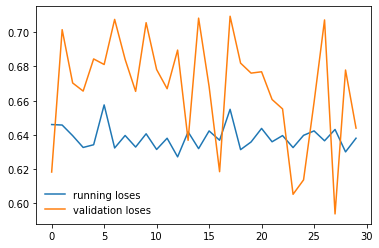

In [38]:
# a plot of the progress with matplotlib
%matplotlib inline
%config InlineBackend.figure_fromat = 'retina'

plt.plot(running_loses, label='running loses')
plt.plot(test_loses, label='validation loses')
plt.legend(frameon=False)

## Visualise the predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[top_class[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

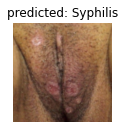

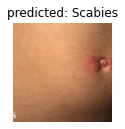

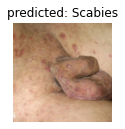

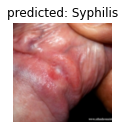

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [40]:
visualize_model(model, num_images=5)

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics

In [42]:
# load the data
inputs, labels = iter(testloader).next()
inputs, labels = inputs.to('cpu'), labels.to('cpu')
model.to('cpu')
print()

In [0]:
# get the predictions
with torch.no_grad():
  model.eval()
  outputs = model(inputs)

In [44]:
# print a summmary of the accuracies
_, predicted = torch.max(outputs, 1)
c = (predicted == labels).squeeze()

class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))

for i in range(len(class_names)):
  label = labels[i]
  class_correct[label] += c[i].item()
  class_total[label] += 1

for i in range(len(class_names)):
  if class_total[i] != 0:
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Scabies : 50 %


In [0]:
#confusion matrix
cm = confusion_matrix(labels, predicted)

Classification report for classifier resnet50:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.65      1.00      0.79        11

    accuracy                           0.70        20
   macro avg       0.82      0.67      0.64        20
weighted avg       0.81      0.70      0.66        20


Confusion matrix:
[[ 3  6]
 [ 0 11]]


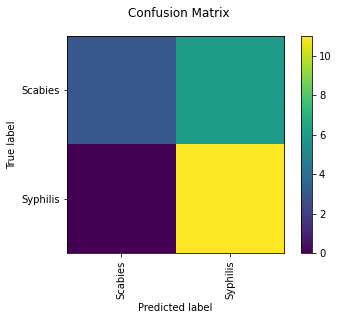

In [46]:
print("Classification report for classifier %s:\n%s\n"
      % (model_name, metrics.classification_report(labels, predicted)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(include_values=None, cmap=None, xticks_rotation='vertical')
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # here, we resize to make the shoter side be 256
    width, height = image.size # get dimensions
    if height > width:
        h = (height/width)*256
        image.thumbnail((h,256))
    elif height < width:
        w = (width/height)*256
        image.thumbnail((256,w))
        
    # center crop
    left = (width-224)/2
    top = (height-224)/2
    right = (width+224)/2
    bottom = (height+224)/2
    
    croped_image = image.crop((left,top,right, bottom))
    
    
    # convert image to floats between 0,1
    np_image = np.array(croped_image)
    np_image.astype(float)
    np_image = np_image/255
    
    # normalise image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image-mean)/std
    
    # transpose image
    npt_image = np_image.transpose()
    return torch.Tensor(npt_image)

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image.squeeze())
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = Image.open(image_path)
    img = process_image(image)
    
    # peform the model classification
    with torch.no_grad():
        model.to('cpu')
        model.eval()
        logs = model(img.unsqueeze_(0))
        ps = torch.exp(logs)
    
        #get the top probalities
        top_p, top_class = ps.topk(topk, dim=1)
    
    classes_idx = []
    top_class = top_class.squeeze()
    for i, x in enumerate(class_names):
        if i in top_class:
            classes_idx.append(i)
            
    return top_p, classes_idx

In [41]:
!wget https://www.dropbox.com/s/fghsglabt92dy6a/warts-plantar-16.jpg?dl=0 -O image3.jpg

--2020-05-03 18:09:59--  https://www.dropbox.com/s/fghsglabt92dy6a/warts-plantar-16.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fghsglabt92dy6a/warts-plantar-16.jpg [following]
--2020-05-03 18:09:59--  https://www.dropbox.com/s/raw/fghsglabt92dy6a/warts-plantar-16.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc73716c23737a459e613ddae241.dl.dropboxusercontent.com/cd/0/inline/A3ChpPWccvvwqHyAEHvjCICJiyrV-KC-f6ANBUIiI9e6w4QaWg35x3kwIOGZrbHw5CbNp0EGyx25l7IhQyxMu9giShb3zZUyBOYc0yrUrMMrMUmeofkh7K_YLoTfLT78e3s/file# [following]
--2020-05-03 18:09:59--  https://uc73716c23737a459e613ddae241.dl.dropboxusercontent.com/cd/0/inline/A3ChpPWccvvwqHyAEHvjCICJiyrV-KC-f6ANBUIiI9e6w4QaWg35x3kwIOGZrbHw5CbNp0EGyx25l7IhQy

In [0]:
img, lbl = iter(testloader).next()

In [127]:
!ls Data/val/Scabies

img18.jpg  img34.jpg  img46.jpg  img49.jpg  img53.jpg  img9.jpg
img32.jpg  img35.jpg  img48.jpg  img52.jpg  img8.jpg


In [0]:
image_path = 'Data/val/Syphilis/img40.jpg'

In [142]:
!ls Data/val/Syphilis

img161.jpg  img38.jpg  img40.jpg  img68.jpg  imgs2.jpg


In [0]:
processed_image = process_image(Image.open(image_path))

In [0]:
probs, classes = predict(image_path, model, topk=2)

In [0]:
def view_classify(img, ps, labels):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,11), ncols=2)
    # im = np.array(img.resize_((28, 28)))
    # ax1.imshow(img.squeeze())
    ax1.axis('off')
    imshow(img, ax=ax1)
    ax2.barh(np.arange(len(labels)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(labels)))
    ax2.set_yticklabels(labels, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

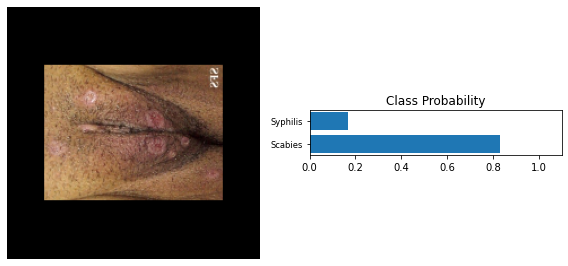

In [162]:
view_classify(processed_image, probs, class_names)

In [0]:
class_names

['Scabies', 'Warts Vulgaris']

## Saving and loading trained models
After trainig the model, it is important to save the current state parameters and all other parameters that may help compare the architectures and the hyperparameters.

In [145]:
checkpoint_dir = 'checkpoints/'
!mkdir checkpoints
!ls

mkdir: cannot create directory ‘checkpoints’: File exists
atlas	     Data	  image3.jpg		      sample_data
checkpoints  data.tar.gz  imbalanced-dataset-sampler


In [0]:
# crete custom dictionary to save additional params
checkpoint = {'epoch': e,
              'learning_rate': learning_rate,
              'arch': 'cpu',
              'optimizer_state_dict': optimizer.state_dict(),
             'model_state_dict': model.state_dict(),
              'loss': loss,
             'duration': duration}

# save the model
torch.save(checkpoint, checkpoint_dir+model_name+'.pth')

In [0]:
# load a saved model from disk to coninue traning
checkpoint = torch.load(checkpoint_dir+model_name+'.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [0]:
# setup for uploading to s3
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

In [0]:
#upload to s3
inputs = sagemaker_session.upload_data(path='checkpoints', bucket=bucket, key_prefix=prefix)

In [0]:
inputs